##  Pitches, scales, elements, frequencies, etc... 
### (1) Frequencies and tonal relationships
### (2) Visualizing tonal relationships 
### (3) Pitch wheels
### (4) Modes -- Dictionaries and lists
### (5) Generating tones (without RTcmix)
### (6) Generating RTcmix scores from lists of pitches

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from subprocess import Popen
import subprocess as sp
import os

import librosa
import sys
sys.path.append('./modules/')

# _ac stands for autocheck
cmixStatus, cmixResult = sp.getstatusoutput("CMIX")
if cmixStatus == 0:
    cmixInstalled = True
    print("CMIX found.")
else:
    cmixInstalled = False
    print("CMIX not found, using pyGoRTcmix instead.")

CMIX found.


# ==============================================
# (1) frequencies and tonal relationships

In s00_make_simple_sounds.ipynb, we made simple tones and chords from sine wave oscillators. 
Here, we will start with a little bit of music theory,
using loops to make sequences of tones of different pitch (scales! arpeggios!)
and then do the same thing using RTcmix, as an introduction. 

This notebook also sneaks in some intro to essential python elements: dictionaries, functions and loops. 

Refs: 
Hermann Helmholtz "On the Sensations of Tone" 1863 !! 
Gareth Loy "Musimathics, vol. 1" 2006

In [6]:
# Octaves
root = 220. # "A3"

# octaves, by multi[;ication of integers (powers of 2): 
octs = np.array([1,2,4,8]) # four octaves
freqs = root*octs
print(freqs)

#same octaves, by integer exponents of base 2. 
octs_exp = np.array([0,1,2,3])
freqs = root*2**octs_exp
print(freqs)


[  220.   440.   880.  1760.]
[  220.   440.   880.  1760.]


### Equal temperament (modern western instruments): 

In classical western music, the octave is divided into 12 equal-sized "semi-tone" intervals: <br>
$f = f_0*2^{v+k/12}$ <br>
$v$ is an integer that marks how many octaves you are above $f_0$ <br>
$k$ are integers that give you the number of intervals of the 12 that make the octave. <br>




In [7]:
k = np.arange(0,12,1) # this makes a numpy array. 
print(k)

v = 0
root = 220
print('all semi-tones:')
f = root*2**(v+k/12)
print(f)

print('major scale:')
# intervals 2,2,1,2,2,2,1 
major = np.array([0,2,4,5,7,9,11,12])
print(major)
f = root*2**(v+major/12)
print(f)

[ 0  1  2  3  4  5  6  7  8  9 10 11]
all semi-tones:
[ 220.          233.08188076  246.94165063  261.6255653   277.18263098
  293.66476792  311.12698372  329.62755691  349.22823143  369.99442271
  391.99543598  415.30469758]
major scale:
[ 0  2  4  5  7  9 11 12]
[ 220.          246.94165063  277.18263098  293.66476792  329.62755691
  369.99442271  415.30469758  440.        ]


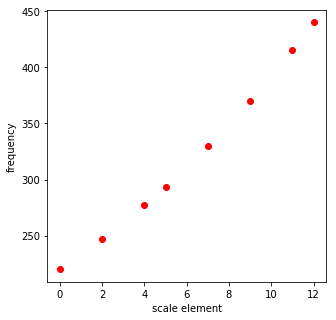

In [8]:
fig = plt.figure(figsize=(5,5))
plt.plot(major,f, 'ro')
plt.xlabel('scale element')
plt.ylabel('frequency')
plt.show()

### Just intonation (sounds better !?!?)
made from ratios of small integers
2/1, 3/2, 4/3, 5/4, 6/5 ;
octave, fifth, fourth, major third, minor third. 
then sort by increasing value! 

In [9]:
top = np.array([2,3,4,5,6])
bot = top-1 
just_ratios = top/bot

print('the ratios of just intonation for octave, fifth, fourth, major third, minor third:')
print(just_ratios)

print('rearranged to minor third, major third, fourth, fifth, octave:')
scale3458_just = np.sort(just_ratios)
print(scale3458_just)

print('add the root note:')
scale13m3M458_just = np.append(1, scale3458_just)
print(scale13m3M458_just)

print('compare to the equal tempered ratios:')
ints13m3M458_eqt = np.array([0,3,4,5,7,12])
scale13m3M458_eqt = 2**(ints13m3M458_eqt/12)
print(scale13m3M458_eqt)

print('Can we hear the difference?')

the ratios of just intonation for octave, fifth, fourth, major third, minor third:
[ 2.          1.5         1.33333333  1.25        1.2       ]
rearranged to minor third, major third, fourth, fifth, octave:
[ 1.2         1.25        1.33333333  1.5         2.        ]
add the root note:
[ 1.          1.2         1.25        1.33333333  1.5         2.        ]
compare to the equal tempered ratios:
[ 1.          1.18920712  1.25992105  1.33483985  1.49830708  2.        ]
Can we hear the difference?


<class 'numpy.ndarray'>
1.11111111111
[  0.           1.11111111   2.22222222   3.33333333   4.44444444
   5.55555556   6.66666667   7.77777778   8.88888889  10.        ]


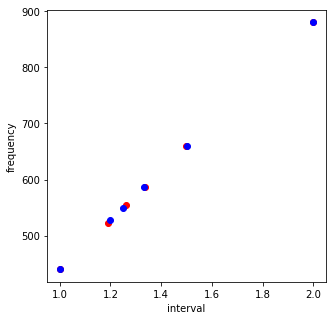

In [10]:
# CONVERT THOSE RATIOS TO FREQUENCIES !
f0 = 440 
f_133458_just = f0*scale13m3M458_just
f_133458_eqt = f0*scale13m3M458_eqt
print(type(f_133458_eqt))

# delete the major or minor thirds
min_ind = 1
maj_ind = 2
f_13458_eqt = np.delete(f_133458_eqt,[min_ind])  #np.delete(values,[3,4,1])
f_13458_just = np.delete(f_133458_just,[min_ind]) 

freqs = np.concatenate((f_13458_just,f_13458_eqt))
# MAKE a TIME array ! 
# use arange for integers !
# use linspace for non-integer increments
sound_dur = 10
time = np.linspace(0,sound_dur,len(freqs)) 
dur = time[2] - time[1]
print(dur)
print(time)

fig = plt.figure(figsize=(5,5))
plt.plot(scale13m3M458_eqt,f_133458_eqt, 'ro')
plt.plot(scale13m3M458_just,f_133458_just, 'bo')
plt.xlabel('interval')
plt.ylabel('frequency')
plt.show()

# ===============================================
# (2) Visualizing tonal relationships ! 

In [11]:
n_oct = 2
n_ints_scl = 24
pitches = np.arange(n_oct*n_ints_scl+1)
print(pitches)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]


In [12]:
f0 = 440.0 
k = pitches
freqs = f0*2**(k/12)
print(freqs)

[  440.           466.16376152   493.88330126   523.2511306    554.36526195
   587.32953583   622.25396744   659.25511383   698.45646287   739.98884542
   783.99087196   830.60939516   880.           932.32752304   987.76660251
  1046.5022612   1108.73052391  1174.65907167  1244.50793489  1318.51022765
  1396.91292573  1479.97769085  1567.98174393  1661.21879032  1760.
  1864.65504607  1975.53320502  2093.0045224   2217.46104781  2349.31814334
  2489.01586978  2637.0204553   2793.82585146  2959.95538169  3135.96348785
  3322.43758064  3520.          3729.31009214  3951.06641005  4186.00904481
  4434.92209563  4698.63628668  4978.03173955  5274.04091061  5587.65170293
  5919.91076339  6271.92697571  6644.87516128  7040.        ]


In [13]:
v = -1 # octave shift down from root (tonic)
freqs = f0*2**(v+k/12)

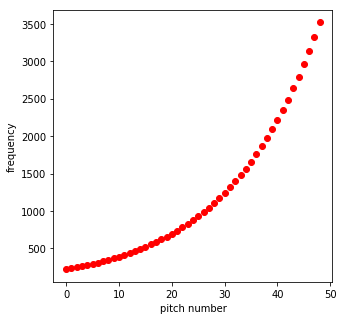

In [14]:
fig = plt.figure(figsize=(5,5))
plt.plot(pitches,freqs, 'ro')
plt.xlabel('pitch number')
plt.ylabel('frequency')
plt.show()

# =============================================================================
# (3) PITCH WHEELS

In [15]:
import matplotlib.patches as patches

def makePitchRing(indexes):
    circle = np.linspace(0,2*np.pi,64)
    r = 1.0
    x = r*np.sin(circle)
    y = r*np.cos(circle)

    # the note locations. 
    base_dots = np.linspace(0,2*np.pi,13)
    xd = r*np.sin(base_dots)
    yd = r*np.cos(base_dots)

    # the text locations
    r = 1.15
    xt = r*np.sin(base_dots)
    yt = r*np.cos(base_dots)

    # ========================
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111, aspect='equal')

    # (0) plot a filled square with a filled circle in it...
    # patches.Rectangle((x,y,lower left corner),width,height)
    #ax1.add_patch(patches.Rectangle((0.1, 0.1),0.5,0.5,facecolor="red"))

    ax1.add_patch(patches.Rectangle((-1.25, -1.25),2.5,2.5,facecolor=[0.6, 0.6, 0.6]))
    ax1.plot(x,y,'k-')
    ax1.plot(xd,yd,'w.')

    radius_norm = 0.08  # radius normalized, scaled to size of box

    for ind,interval in enumerate(indexes):
        # print(ind,interval)
        ax1.add_patch(patches.Circle((xd[interval], yd[interval]),radius_norm,facecolor="red")) 
        ax1.text(xt[interval], yt[interval],pitch_classes[interval])
        
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    plt.show()


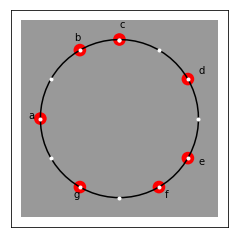

In [16]:
pitch_classes = ['c','c#','d','d#','e','f','f#','g','g#','a','a#','b']
indexes = [0,2,4,5,7,9,11]
makePitchRing(indexes)

In [17]:
# Now lets make a sort of data base for pitches... 
# to connect names to pitches, 
# and 

C4 = 440.0 * 2**(3/12-1)
print(C4)

def notenum2freq(k,v,f0):
    freqs = f0*2**(v+k/12)
    return freqs

ints = np.arange(12)
print(ints)
ref_scale_freqs = notenum2freq(ints,0,C4)
print(ref_scale_freqs)

261.6255653005986
[ 0  1  2  3  4  5  6  7  8  9 10 11]
[ 261.6255653   277.18263098  293.66476792  311.12698372  329.62755691
  349.22823143  369.99442271  391.99543598  415.30469758  440.
  466.16376152  493.88330126]


In [18]:
# using dictionaries: 
# https://learnpythonthehardway.org/book/ex39.html
# https://jeffknupp.com/blog/2015/08/30/python-dictionaries/

# a list of dictionaries: 
# http://stackoverflow.com/questions/19577258/python-analog-to-matlab-data-structure
# database.append({'E': 17e4, 'var2': 'C:\\data file path', 'var3': [1, 2, 3, 4]})
pitch_classes = ['c','c#','d','d#','e','f','f#','g','g#','a','a#','b']

# does it make any sense to make a dictionary here?
#pitches_midC_ref = {'pitches':pitch_classes, 'freqs':ref_scale_freqs }
#pitch_names = pitches_midC_ref['pitches']
#freqs = pitches_midC_ref['freqs']


In [19]:
for pair in zip(pitch_classes,ref_scale_freqs):
    print(pair)

for ind,pitchname in enumerate(pitch_classes):
    print(pitchname + ' : ' + str(ref_scale_freqs[ind]))
    

('c', 261.62556530059862)
('c#', 277.18263097687208)
('d', 293.66476791740757)
('d#', 311.12698372208087)
('e', 329.62755691286992)
('f', 349.22823143300388)
('f#', 369.9944227116344)
('g', 391.99543598174927)
('g#', 415.30469757994507)
('a', 439.99999999999994)
('a#', 466.16376151808987)
('b', 493.88330125612407)
c : 261.625565301
c# : 277.182630977
d : 293.664767917
d# : 311.126983722
e : 329.627556913
f : 349.228231433
f# : 369.994422712
g : 391.995435982
g# : 415.30469758
a : 440.0
a# : 466.163761518
b : 493.883301256


In [20]:
# or make a dictionary ! 
pitch_freq_ref = dict(zip(pitch_classes,ref_scale_freqs))

pitch_freq_ref
print(pitch_freq_ref)


{'c': 261.62556530059862, 'c#': 277.18263097687208, 'd': 293.66476791740757, 'd#': 311.12698372208087, 'e': 329.62755691286992, 'f': 349.22823143300388, 'f#': 369.9944227116344, 'g': 391.99543598174927, 'g#': 415.30469757994507, 'a': 439.99999999999994, 'a#': 466.16376151808987, 'b': 493.88330125612407}


In [21]:
# is this actually C4 ? 
print('============== CALL ONE PITCH NAME ============')
C4 = pitch_freq_ref['c']
print('C4 = '+ str(C4))

============== CALL ONE PITCH NAME ============
C4 = 261.625565301


# =============================================
# (4) Modes -- Dictionaries and lists

In [22]:
# NOW LETS MAKE DICTIONARIES FOR THE MODES !! 

modes = {
    'ionian':[2,2,1,2,2,2,1],
    'dorian':[2,1,2,2,2,1,2],
    'phrygian':[1,2,2,2,1,2,2],
    'lydian':[2,2,2,1,2,2,1],
    'mixolydian':[2,2,1,2,2,1,2],
    'aeolian':[2,1,2,2,1,2,2],
    'lochrian':[1,2,2,1,2,2,2]
}

print(len(modes))

7


In [23]:
# calculate the elements of the scale from the intervals (a sort of integral): 

intervals = modes['phrygian']
print(intervals)

x = np.cumsum(intervals)
print(x)
indexes2 = [0]
for val in x[:-1]:
    indexes2.append(val)

indexes2 = np.array(indexes2)
print(type(indexes2))

[1, 2, 2, 2, 1, 2, 2]
[ 1  3  5  7  8 10 12]
<class 'numpy.ndarray'>


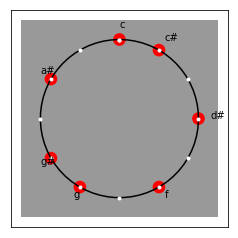

In [24]:
makePitchRing(indexes2)

# =======================================================================
# (5) Generating Beeps ! 

In [25]:
# define the function for making the ENVELOPE
#  peak position [0,1] 
def make_envelope_3pt(y,peak_posn):
    N = len(y)
    envelope = np.zeros(N)
    #print(envelope.shape)
    peak = int(N*peak_posn)
    #print(peak)

    # from 0 to the peak index (peak):
    up = np.linspace(0,1,peak)
    #print(up.shape)
    envelope[:peak] = up

    # and fill in the rest: 
    down = np.linspace(1,0,(N-peak))
    #print(down.shape)
    envelope[peak:] = down
    
    return envelope

# there is a much shorter and more elegant way to do this, actually many ! 
# make one using np.interp with the time vector of the signal to modulate! 

In [26]:
# define the function for MAKING THE BEEP, then taking in the envelope
# inputs f, dur

def make_oscillator(f,dur):
    n_cycles = f*dur # [cycles/sec]*[sec]
    fs = 44100 # just make it at 44100.. why not?! 
    npts = int(fs*dur)
    
    time = np.linspace(0,dur,npts)
    env = np.interp(time, [0,0.05*dur,0.95*dur,dur], [0,1,1,0])
    x = np.linspace(0,2*np.pi*n_cycles,npts)
    y = np.sin(x)
    y = env*y
    return time,y


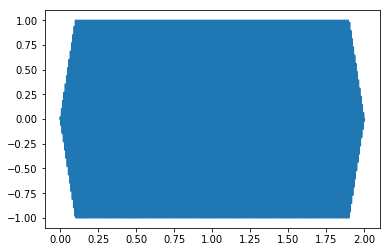

In [27]:
f = 120.0
dur = 2.0
time,y = make_oscillator(f,dur)
plt.plot(time,y)

In [28]:
# loop over the scale to generate the beep sequence
# CONVERT THOSE RATIOS TO FREQUENCIES !
C4 = pitch_freq_ref['c']
print('C4 = '+ str(C4))

f0 = C4 
f_133458_just = f0*scale13m3M458_just
f_133458_eqt = f0*scale13m3M458_eqt
print(type(f_133458_eqt))

# delete the major or minor thirds
min_ind = 1
maj_ind = 2
f_13458_eqt = np.delete(f_133458_eqt,[min_ind]) 
f_13458_just = np.delete(f_133458_just,[min_ind]) 

freqs = np.concatenate((f_13458_just,f_13458_eqt))
print(f_13458_just)
print(f_13458_eqt)

C4 = 261.625565301
<class 'numpy.ndarray'>
[ 261.6255653   327.03195663  348.83408707  392.43834795  523.2511306 ]
[ 261.6255653   329.62755691  349.22823143  391.99543598  523.2511306 ]


In [29]:
dur = 1.4

waveform = np.zeros(1)
for ff in freqs:
    time,y = make_oscillator(ff,dur)
    beep = y
    waveform = np.hstack((waveform,beep))

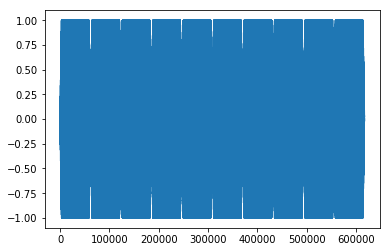

In [30]:
plt.plot(waveform)

In [40]:
DirOut = '../3_output_nogit/'
OutFileName = 'scales1_noRT.wav'
fs_sound = 44100
librosa.output.write_wav(DirOut + OutFileName, waveform, fs_sound, norm=False)

# ==========================================================
# (6) generating RTcmix scores from simple lists of pitches
### same as above but with RTcmix

In [45]:
# FUNCTION FOR GENERATING THE RTcmix score ! 

def makeSimpleScore(base_name,time,freqs):
    # ====================
    score_name = base_name + '.sco'
    print(score_name)
    f_out = open("./" + score_name , 'w')
    # YOU MUST DELETE THE SOUND FILE BEFORE RUNNING (either with python or with -clobber )
    f_out.write("set_option(\"clobber = on\")")

    f_out.write("rtsetparams(44100, 1)\n")
    f_out.write("load(\"WAVETABLE\")\n")

    # output_string = 'rtoutput(\"' + base_name + '.wav\")\n'  
    # don't need the brackets to make it an array ! 
    # f_out.write(output_string)

    #----------------------CHECK IF CMIX COMMAND IS INSTALLED-----------------------
    #only use rtoutput if CMIX command is found.
    cmixStatus, cmixResult = sp.getstatusoutput("CMIX")
    #the cmixInstalled variable can also be passed from the notebook
    #in that is case, the output of sp.getstatusoutput("CMIX") is overridden

    if cmixInstalled:
        cmixStatus = 0
    else:
        cmixStatus = 127

    if cmixStatus == 0:
        output_string = 'rtoutput(\"' + base_name + '.wav\")\n'
        # don't need the brackets to make it an array !
        print("CMIX found.")
        print(output_string)
        f_out.write(output_string)
    else:
        print("CMIX not found; rtoutput() will not be used in score.")
    #-------------------------------------------------------------------------------
    
    f_out.write("waveform = maketable(\"wave\", 1000, 1.0)\n")
    # to add overtones, just add amplitude weights
    #f_out.write("waveform = maketable(\"wave\", 1000, 1.0, 0.4, 0.2)\n")

    f_out.write("ampenv = maketable(\"window\", 1000, \"hamming\")\n")    

    # write out the score ! 
    # (start time, duration, amplitude, frequency, channel mix [0 left, 1.0 right],
    # table_handle (which waveform to use)

    # for now, constants: 
            
    # reset(44100) makes it very very smooth... 
            
    amp = 10000 
    mix = 1.0 # 0 = left, 1 = right, but here just 1 channel
    tab_han = 'waveform'

    for i,freq_val in enumerate(freqs):
        t_start = time[i]
        # dur = durations[i]-- here, constant, defined above
        dur = 1.4
        freq = freq_val
        note_string = 'WAVETABLE(' + str(t_start) + ', ' \
                  + str(dur)  + ', ' + str(amp)+ '*ampenv' + ', ' \
                  + str(freq)  + ', ' + str(mix)  + ', ' \
                  +  tab_han + ')\n' 
        f_out.write(note_string)
        
    f_out.close()
    return score_name



In [46]:
# Make freqs and time arrays (same length!)
freqs = np.concatenate((f_13458_just,f_13458_eqt))
beepdur = 1.4
sound_dur = len(freqs)*beepdur
time_sco = np.linspace(0,sound_dur,len(freqs))
print(len(freqs),len(time_sco))
print(time_sco)

10 10
[  0.           1.55555556   3.11111111   4.66666667   6.22222222
   7.77777778   9.33333333  10.88888889  12.44444444  14.        ]


In [47]:
# GENERATE THE RTcmix score ! 
base_name = 'scale1_RT'
score_name = makeSimpleScore(base_name,time_sco,freqs)



scale1_RT.sco
CMIX found.
rtoutput("scale1_RT.wav")



In [50]:
# play RTcmix score and create a wave file
# use CMIX if installed; if not, use pyGoRTcmix
abitextra = 0.5
dur_sound = time_sco[-1] + abitextra 

if cmixInstalled:
    cmix_cmd = 'CMIX < ' + base_name + '.sco'
else:
    dur = str(dur_sound)
    cmix_cmd = '../pyGoRTcmix/pyGoRTcmix -inputscore ' + os.path.abspath(base_name + '.sco ') + '-output ' + os.path.abspath(base_name + '.wav ') +'-dur ' + dur
print(cmix_cmd)

runCMIX = sp.Popen(cmix_cmd, shell=True) # if can only be called from a shell, use shell=True

runCMIX.wait()
print('\nhopefully i just wrote your sound file (' + base_name + '.wav); is it here?')
! ls *.wav

CMIX < scale1_RT.sco

hopefully i just wrote your sound file (scale1_RT.wav); is it here?
scale1_RT.wav sound_env.wav


In [52]:
move_cmd = 'mv ' + base_name + '.* ../3_output_nogit/'
sp.Popen(move_cmd, shell=True)

In [29]:
# EXERCISE:  MAKE AN RTCMIX SCORE FROM THIS... 
base_name = 'phrygian_c'
# pluck freqs out of the scale... or calculate freqs with k ? 
freqs = notename2freq(indexes2,0,C4)
print(freqs)
time2 = np.linspace(0,10,len(indexes2))

makeSimpleScore(base_name,time,freqs)

[ 261.6255653   277.18263098  311.12698372  349.22823143  391.99543598
  415.30469758  466.16376152]
rtoutput("phrygian_c.wav")



'phrygian_c.sco'

In [58]:
# EXERCISE:  CHANGE THE ROOT NOTE OF THE SCALE ! 


In [ ]:
# EXERCISE: STRING TOGETHER A SERIES OF SCALES, LOOPING OVER ONE THING TO CHANGE, 
# such as root note or mode... and make a longer RTcmix score... 

### (7) Circles of 5ths and 4ths... 
### (8) More considerations for composing from data.. chords... key changes, microtonal scales... 